# 3.1 Isotherm fitting method: isofit

## 3.1.1 Pure isotherm fitting

In [1]:
import pyapep.isofit as isofit

# Generate dummy data
P = [2, 3, 4, 5]
q_comp = [1, 2, 3, 4]     # Gas adsorption of a component

# Define pure isotherm of each component
iso, param, fntype, err = isofit.best_isomodel(P, q_comp)

## 3.1.2 Fitting for different temperatures

In [1]:
from pyapep import isofit
import numpy as np
# Generate a data dummy data
qm_dum = 4.5 # mol/kg
K1_dum = 3.0 # 1/bar
K2_dum = 0.5 # 1/(bar^2)
P_dum = np.linspace(0, 2, 9)
T_dum = [280, 300, 305, 310, 320] # dummy T
dH_dum = 25000 # J/mol : heat of adsorption
R_gas = 8.3145
T_ref = T_dum[1] # Reference temperature = 300 K

q_dum = []
for T in T_dum:
    P_norm = np.exp(dH_dum/R_gas*(1/T - 1/T_ref))*P_dum
    err_dum = 0.05*np.random.rand(len(P_norm))
    q_tmp = qm_dum*(K1_dum*P_norm + 2*K2_dum*P_norm**2)/(
            1+ K1_dum*P_norm + K2_dum*P_norm**2)
    q_w_err = q_tmp + err_dum
    q_dum.append(q_w_err)
# Use isofit
P_list = [P_dum,]*len(q_dum)
res_diffT = isofit.fit_diffT(P_list,q_dum, T_dum, 1, tol = 2E-4)
iso_function, iso_param, zerr = res_diffT[:3]
fit_error, dH_found, Tref_found, theta_list = res_diffT [3:]
print("This data is fitted with {}.".format(zerr))

# Prediction for different T
P_pred = np.linspace(0,2.5, 51)
q_pred = []
for T in T_dum:
    q_tmp =iso_function(P_pred, T)
    q_pred.append(q_tmp)

This data is fitted with Quadratic.


## 3.1.3 Mixture isotherm

In [ ]:
from pyapep import isofit
import numpy as np
# Pure isotherm functions
def iso1(P,T):
    deno = 1 + 0.3*P
    nume = 2*0.3*P
    return  nume/deno
def iso2(P,T):
    deno = 1 + 0.3*P + 0.1*P**2
    nume = 2*(0.3*P + 2*0.1*P**2)
    return nume/deno
def iso3(P,T):
    return 2*P**0.4

iso_list = [iso1, iso2, iso3]
P_arr = np.linspace(0,4,9)  # pressure (bar)
T = 300    # temperature (K) 
y_gas = [] # mole fraction (mol/mol)
y1 = [0, 0.2, 0.4, 0.6] # mol. frac. of 1 (mo/mol)
for y in y1:
    y_tmp = np.array([y, 0.6-y, 0.4])
    y_gas.append(y_tmp)
q_comp1 = []
q_comp2 = []
for yy in y_gas:
    res_list = []
    q1_tmp = []
    q2_tmp = []
    for p in P_arr:
        res_tmp = isofit.IAST(iso_list,p*yy, T)
        res_list.append(res_tmp)
        q1_tmp.append(res_tmp[0])
        q2_tmp.append(res_tmp[1])
    q_comp1.append(q1_tmp)
    q_comp2.append(q2_tmp)

In [ ]:
#### Display ####
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots(dpi = 100)
fig2, ax2 = plt.subplots(dpi = 100)
fsize = 14
markers = np.array(['o-','s--','D-.','^:'])
for q1, q2, y, ma in zip(q_comp1, q_comp2, y1, markers): 
    ax1.plot(P_arr, q1, 'k'+ ma ,
            linewidth = 1.8, markersize = 7,
            label = 'mole fraction = {0:.1f}'.format(y))

    ax2.plot(P_arr, q2, 'k'+ ma,
            linewidth = 1.8, markersize = 7,
            label = 'mole fraction = {0:.1f}'.format(0.6-y))
ax1.set_xlabel('Overall pressure (bar)',fontsize = fsize)
ax2.set_xlabel('Overall pressure (bar)',fontsize = fsize)
ax1.set_ylabel('Uptake (mol/kg)', fontsize = fsize)
ax2.set_ylabel('Uptake (mol/kg)', fontsize = fsize)
ax1.tick_params(labelsize = fsize-2)
ax2.tick_params(labelsize = fsize-2)

ylim_tmp = ax1.get_ylim()
ylim_list = list(ylim_tmp)
ylim_list[1] = ylim_list[1]*1.3
ax1.set_ylim(ylim_list)

ylim_tmp = ax2.get_ylim()
ylim_list = list(ylim_tmp)
ylim_list[1] = ylim_list[1]*1.3
ax2.set_ylim(ylim_list)

ax1.grid(which='major', linestyle = ':')
ax2.grid(which='major', linestyle = ':')
ax1.legend(fontsize = fsize)
ax2.legend(fontsize = fsize)

fig1.savefig('fig_comp1.png', bbox_inches = 'tight')
fig2.savefig('fig_comp2.png', bbox_inches = 'tight')

# 3.2. Ideal PSA process performances: simide

## 3.2.1 Mixture isotherm function and column definition

In [7]:
# Package import
import pyapep.isofit as isofit
import pyapep.simide as simide

# Generate dummy data
P = [2, 3, 4, 5]
q_comp1 = [1, 2, 3, 4]     # Gas adsorption of component 1
q_comp2 = [1, 5, 7, 10]    # Gas adsorption of component 2

# Define pure isotherm of each component
iso1, param1, fntype1, err1 = isofit.best_isomodel(P, q_comp1)
iso2, param2, fntype2, err2 = isofit.best_isomodel(P, q_comp2)

# Mixture isotherm function definition
# iso1 and iso2 == Pure isotherm function of each component.
iso_mix = lambda P,T: isofit.IAST([iso1, iso2], P, T)

In [2]:
# The number of components
num_comp = 2                     
# Ideal column definition
Column1 = simide.IdealColumn(num_comp, iso_mix )  

ERROR: the input should be in the form of "isotherm_fun(P, T)" 


## 3.2.2 Feed and operating condition setting

In [ ]:
# Feed condition setting
P_feed = 8                    # Feed pressure (baobtained)
T_feed = 300                  # Feed temperature (K)
y_feed = [1/4, 3/4]           # Feed mole fraction (mol/mol)

# Update the feed condition
Column1.feedcond(P_feed, T_feed, y_feed)

# Operating condition setting
P_high = 8                          # High pressure (bar)
P_low  = 1                          # Low pressure (bar)

# Update the operating condition
Column1.opercond(P_high, P_low)

## 3.2.3 Run simulation

In [ ]:
# Run simulation
x_ext = Column1.runideal()

# 3.3 Operation of adsorption process: simsep

In [8]:
# Import some package for simulation and visualization
import pyapep.simsep as simsep   
import numpy as np              
import matplotlib.pyplot as plt  

# Define parameters of extended Langmuir isotherm 
qm1 = 1
qm2 = 0.1
b1 = 0.5
b2 = 0.05

dH1 = 1000     # J/mol
dH2 = 1500     # J/mol
R_gas = 8.3145 # J/mol/K
T_ref = 300    # K

# Define the isotherm 
def extLang(P, T):
    P1 = P[0]*np.exp(dH1/R_gas*(1/T-1/T_ref))
    P2 = P[1]*np.exp(dH1/R_gas*(1/T-1/T_ref))
    deno = 1 + b1*P1 + b2*P2
    q1 = qm1*b1*P1 / deno
    q2 = qm2*b2*P2 / deno
    return q1, q2

## 3.3.1 Column design and property information

In [9]:
# Set the design parameter of a column
col_len         = 1      # (m)                                  
cross_sect_area = 0.0314 # (m^2)                                    
num_comp        = 2

# Column definition
Column1 = simsep.column(col_len, cross_sect_area, num_comp)  

In [10]:
# Set the adsorbent information
voidfrac = 0.4                                          
rho      = 1100  #(kg/m^2)                         

# Update the adsorbent information of the column
Column1.adsorbent_info(extLang, voidfrac, rho_s = rho) 

## 3.3.2 Boundary and initial conditions

In [11]:
# Gas property information
Mmol = [0.032, 0.044]   # Molecular weights of gases (kg/mol)
visc = [0.01, 0.01]     # Viscosities of gases (Pa sec)

# Update gas property of the column
Column1.gas_prop_info(Mmol, visc)

In [12]:
# Mass transfer information
MTC = [0.05, 0.05]   # Mass transfer coefficients
a_surf = 400         # Volumetric specific surface area (m2/m3)

# Update mass transfer information of the column
Column1.mass_trans_info(MTC, a_surf) 

# Thermal information
dH_ads = [1000,1000]    # Heat of adsorption (J/mol)
Cp_s = 5                # Solid heat capacity (J/kg K)
Cp_g = [10,10]          # Gas heat capacity (J/mol K)
h_heat = 10             # Heat transfer coefficient 
                        # between solid and gas (J/m^2 K s)

# Update thermal information of the column
Column1.thermal_info(dH_ads, Cp_s, Cp_g, h_heat) 

In [13]:
# Boundary condition
P_inlet  = 9.0            # Inlet pressure  (bar)
P_outlet = 8.0            # Outlet pressure (bar)
T_feed   = 300            # Feed in temperature (K)
y_feed = [0.5,0.5]        # Feed composition (mol/mol)

# Update boundary condition
Column1.boundaryC_info(P_outlet, P_inlet, T_feed, y_feed)

# Initial condition

# Initial pressure (bar)
P_init = 8*np.ones(11)                
# Gas phase mol fraction (mol/mol)
y_init = [0.2*np.ones(11), 0.8*np.ones(11)]
# Initial gas temperature (K)
Tg_init = 300*np.ones(11)          
# Initial solid temperature (K)
Ts_init = 300*np.ones(11)             
# Partial pressure (bar)
P_partial = [P_init*y_init[0], P_init*y_init[1]] 
# Solid phase uptake (mol/kg)
q_init = extLang(P_partial, Ts_init)  

# Update initial condition
Column1.initialC_info(P_init, Tg_init, Ts_init, y_init, q_init)

## 3.3.3 Run simulation

In [14]:
# Simulation run
y, z, t = Column1.run_mamoen(2000, n_sec=10, CPUtime_print=True)

Simulation of this step is completed.
This took     0.074 mins to run. 



## 3.3.4 Visualization of simulation results

(<Figure size 630x450 with 1 Axes>,
 <AxesSubplot:xlabel='z-domain (m)', ylabel='Soild concentration (uptake) (mol/kg)'>)

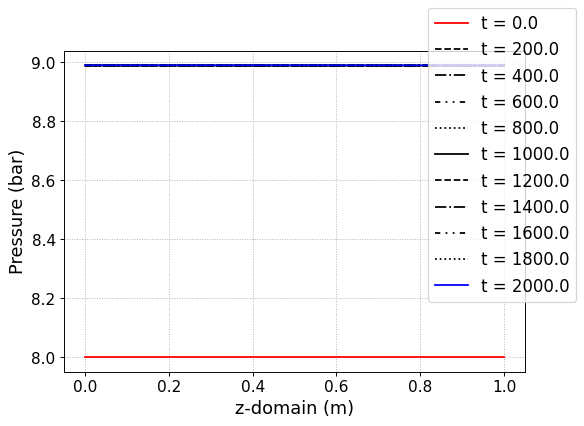

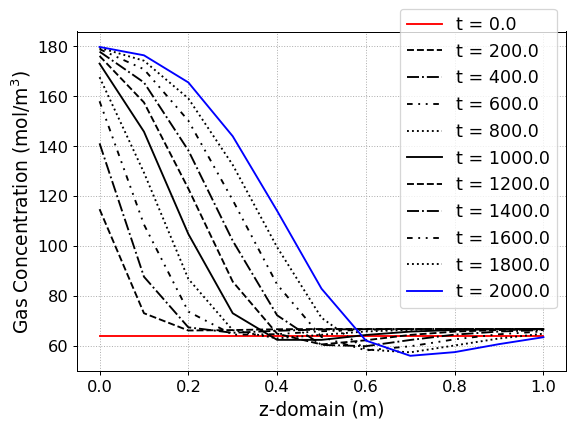

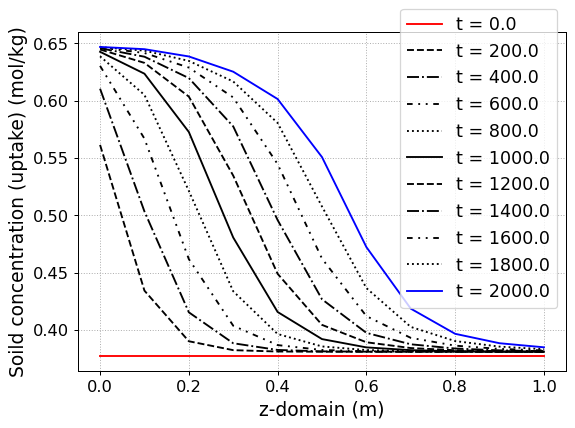

In [15]:
# Visualization of the results

# Simulation result: Pressure according to z-domain
Column1.Graph_P(200) 
# Simulation result: Gas concentration according to z-domain
Column1.Graph(200, 0, yaxis_label=
'Gas Concentration (mol/m$^3$)',loc = [0.9, 0.95])    
# Simulation result: Solid concentration according to z-domain
Column1.Graph(200, 2, yaxis_label=
'Soild concentration (uptake) (mol/kg)',loc = [0.9, 0.95])